# Ejemplo de Modelos de regresión

**Autor**: Alejandro Alonso Puig + ChatGPT-5. https://github.com/aalonsopuig

**Fecha**: Octubre 2025

**Licencia**: Apache 2.0

### Objetivos

Este notebook tiene como objetivo aplicar diferentes modelos de clasificación supervisada sobre el conjunto de datos de cáncer de mama (`breast_cancer`) incluido en `scikit-learn`. A lo largo del cuaderno se pretende:

- Cargar y explorar el dataset, incluyendo análisis de distribución y correlación de variables.  
- Detectar posibles problemas como clases desbalanceadas y aplicar soluciones adecuadas.  
- Preparar los datos mediante escalado y división en conjuntos de entrenamiento y prueba.  
- Entrenar tres modelos de clasificación: regresión logística, k-vecinos (KNN) y árbol de decisión.  
- Evaluar y comparar el rendimiento de los modelos mediante métricas como accuracy, precision, recall y F1-score.  
- Visualizar la matriz de confusión para interpretar los aciertos y errores de clasificación.  
- Detectar posibles casos de sobreajuste (overfitting) en los modelos evaluando su rendimiento en entrenamiento y prueba.  
- Guardar el modelo más prometedor y realizar predicciones sobre nuevos datos.

El enfoque busca ser didáctico y progresivo, con explicaciones detalladas para facilitar la comprensión por parte de estudiantes que se estén iniciando en el aprendizaje automático supervisado.


### Preparación del entorno

Importamos las librerías necesarias para todo el proceso.

In [22]:
# --- Librerías base ---
import pandas as pd                                     # Manejo de estructuras de datos tipo DataFrame (tablas)
import numpy as np                                      # Operaciones numéricas, arrays, estadísticas básicas

# --- Carga y partición del dataset ---
from sklearn.datasets import load_breast_cancer         # Carga el dataset de cáncer de mama preinstalado en sklearn
from sklearn.model_selection import train_test_split    # Divide el dataset en conjuntos de entrenamiento y prueba

# --- Preprocesado de datos ---
from sklearn.preprocessing import StandardScaler        # Escala las variables numéricas (media 0, varianza 1)

# --- Modelos de clasificación ---
from sklearn.linear_model import LogisticRegression     # Modelo de regresión logística (clasificación lineal)
from sklearn.neighbors import KNeighborsClassifier      # Modelo basado en vecinos más cercanos (KNN)
from sklearn.tree import DecisionTreeClassifier         # Modelo de árbol de decisión (clasificación jerárquica)

# --- Evaluación del rendimiento ---
from sklearn.metrics import accuracy_score              # Porcentaje de aciertos globales (accuracy)
from sklearn.metrics import precision_score             # Precisión: positivos predichos correctos
from sklearn.metrics import recall_score                # Sensibilidad: positivos reales detectados
from sklearn.metrics import f1_score                    # F1-score: media armónica entre precisión y recall
from sklearn.metrics import confusion_matrix            # Matriz de confusión (recuento de aciertos/errores)
from sklearn.metrics import ConfusionMatrixDisplay      # Herramienta para mostrar gráficamente la matriz


### Recolección de datos

Esta parte del código carga el conjunto de datos sobre cáncer de mama desde scikit-learn y lo transforma en un DataFrame de pandas para facilitar su visualización y análisis.

In [2]:
data = load_breast_cancer()                               # Carga el dataset de cáncer de mama (features y etiquetas)
X = pd.DataFrame(data.data, columns=data.feature_names)   # Convierte las características en un DataFrame con nombres de columnas
y = pd.Series(data.target)                                # Convierte las etiquetas (0 = maligno, 1 = benigno) en una Serie de pandas


### Análisis y preprocesamiento de datos

Antes de entrenar un modelo, conviene responder a preguntas como:

*   ¿Faltan datos?
*   ¿Hay variables con escalas muy distintas?
*   ¿Hay outliers evidentes?
*   ¿Es necesario normalizar o escalar?
*   ¿Todas las variables son numéricas?

**Visualizar las primeras filas**. sirve para:

- Verificar que los datos se han cargado correctamente
- Entender la estructura del dataset (columnas, tipos de datos, escalas)
- Detectar posibles valores atípicos o faltantes al primer vistazo

Es un paso básico antes de cualquier análisis o modelado.

In [3]:
print("Primeras filas de X (características):")
display(X.head())        # Muestra las primeras 5 filas de las características

print("Primeras etiquetas (y):")
print(y.head().to_list())  # Muestra las primeras 5 etiquetas en forma de lista



Primeras filas de X (características):


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Primeras etiquetas (y):
[0, 0, 0, 0, 0]


**Muestras y desbalanceo**

Este bloque cuenta cuántos ejemplos hay de cada clase en el conjunto de datos. Esto permite saber si el dataset está balanceado (mismo número de muestras por clase) o desbalanceado (una clase tiene muchas más muestras que otra).

In [4]:
import pandas as pd

# Contar el número de muestras por clase
conteo_clases = pd.Series(y).value_counts()
print("Número de muestras por clase:")
print(conteo_clases)

# Calcular el porcentaje de cada clase
porcentajes = conteo_clases / len(y) * 100
print("\nPorcentaje de cada clase:")
print(porcentajes.round(2))


Número de muestras por clase:
1    357
0    212
Name: count, dtype: int64

Porcentaje de cada clase:
1    62.74
0    37.26
Name: count, dtype: float64


Análisis del balance de clases:

- Hay 357 muestras de la clase 1 (alrededor del 63% del total).
- Hay 212 muestras de la clase 0 (alrededor del 37% del total).

Aunque no es un desbalance extremo, sí se observa un cierto desequilibrio entre ambas clases. Esto puede influir en el rendimiento del modelo, ya que podría tender a favorecer la clase mayoritaria (1) si no se corrige o se tiene en cuenta durante el entrenamiento o evaluación.

Usaremos la opción `class_weight='balanced'` en el modelo para que dé más peso a la clase minoritaria durante el entrenamiento, sin modificar los datos originales.

**Verificar valores nulos**
Verificamos valores nulos para evitar errores durante el entrenamiento y asegurar que el modelo trabaje con datos completos y consistentes.

In [5]:
print("\nCantidad de valores nulos por variable:")
print(X.isnull().sum())                     # Comprueba valores faltantes



Cantidad de valores nulos por variable:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64


**Histograma de distribución de las variables**

Esto permite ver si los datos están centrados, si hay sesgo o outliers visuales. Si aparecen variables con distribuciones muy asimétricas, valores extremos o escalas diferentes, conviene considerar normalización o transformación logarítmica.

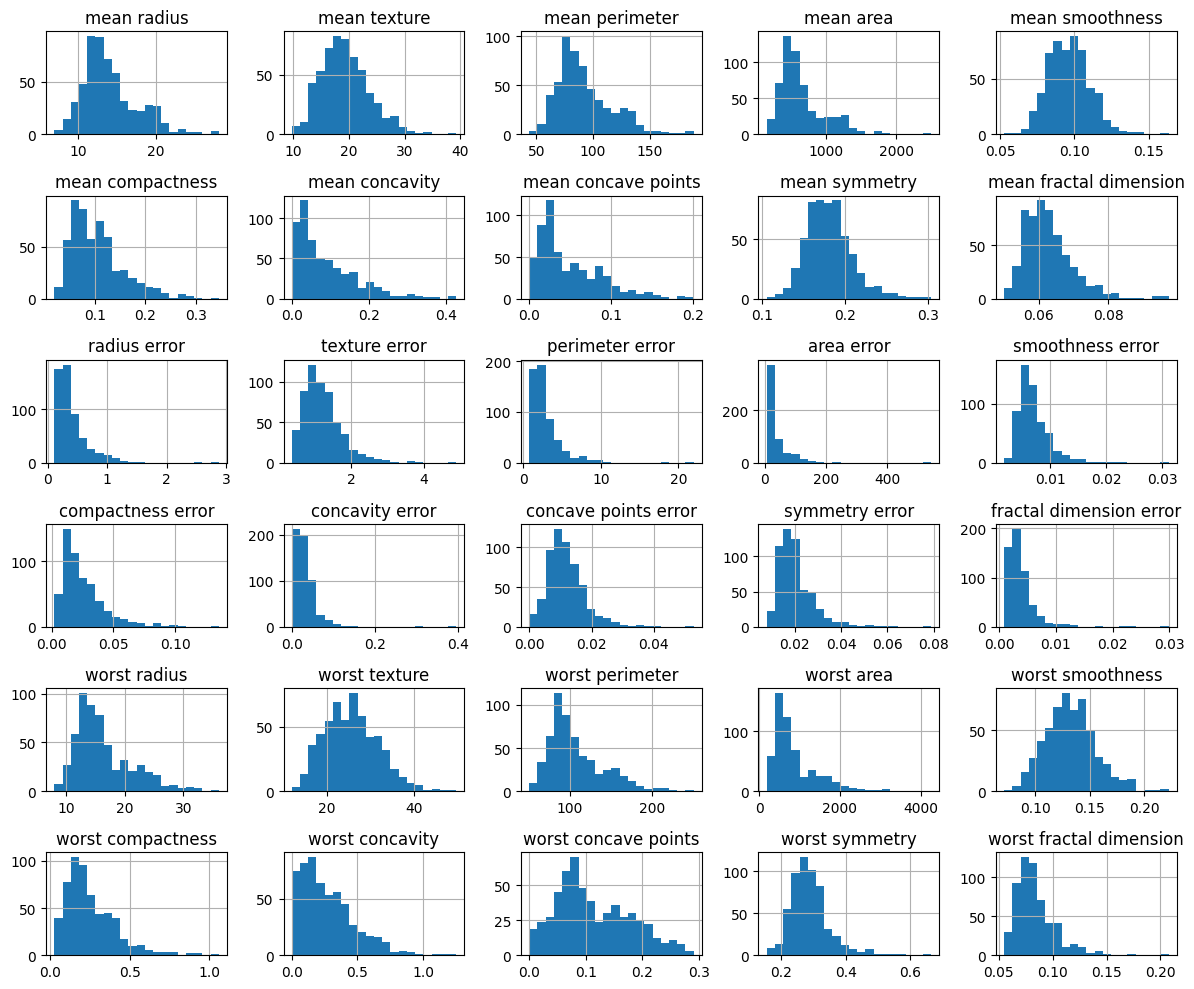

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

X_df = pd.DataFrame(X, columns=data.feature_names)  # Convertimos X a DataFrame para facilitar los nombres
X_df.hist(bins=20, figsize=(12, 10))                 # Dibuja un histograma para cada variable
plt.tight_layout()                                   # Ajusta el espacio entre gráficas
plt.show()


*Observaciones*: Al analizar la forma de las distribuciones de las variables del dataset, observamos que muchas de ellas no siguen una distribución normal. En la mayoría de los casos, presentan sesgo hacia valores más bajos, con colas alargadas hacia valores más altos. Esto indica que los datos están agrupados en valores pequeños pero con algunos casos que se alejan considerablemente por encima del promedio.

Este tipo de comportamiento es habitual en datos biomédicos, donde ciertas mediciones tienden a valores bajos con algunos casos extremos.

Aunque no todas las variables tienen una forma ideal para algoritmos sensibles a la normalidad, este dataset puede utilizarse directamente en modelos robustos de clasificación, como árboles de decisión o K vecinos. En el caso de utilizar métodos que requieren escalado o que se ven afectados por variables no normalizadas, como la regresión logística o las máquinas de vectores soporte, se recomienda aplicar técnicas de estandarización o normalización a las variables.

En nuestro caso, vamos a continuar sin transformar las variables, dado que el modelo que emplearemos en primera instancia (por ejemplo, un árbol de decisión) no requiere que las variables sigan una distribución concreta.

**Mapa de calor de correlaciones**

El mapa muestra cómo se relacionan entre sí las variables del conjunto de datos. Los valores cercanos a 1 indican correlaciones positivas fuertes (ambas variables aumentan o disminuyen juntas), mientras que los valores cercanos a -1 indican correlaciones negativas fuertes (una variable sube cuando la otra baja). Valores cercanos a 0 indican poca o ninguna correlación.

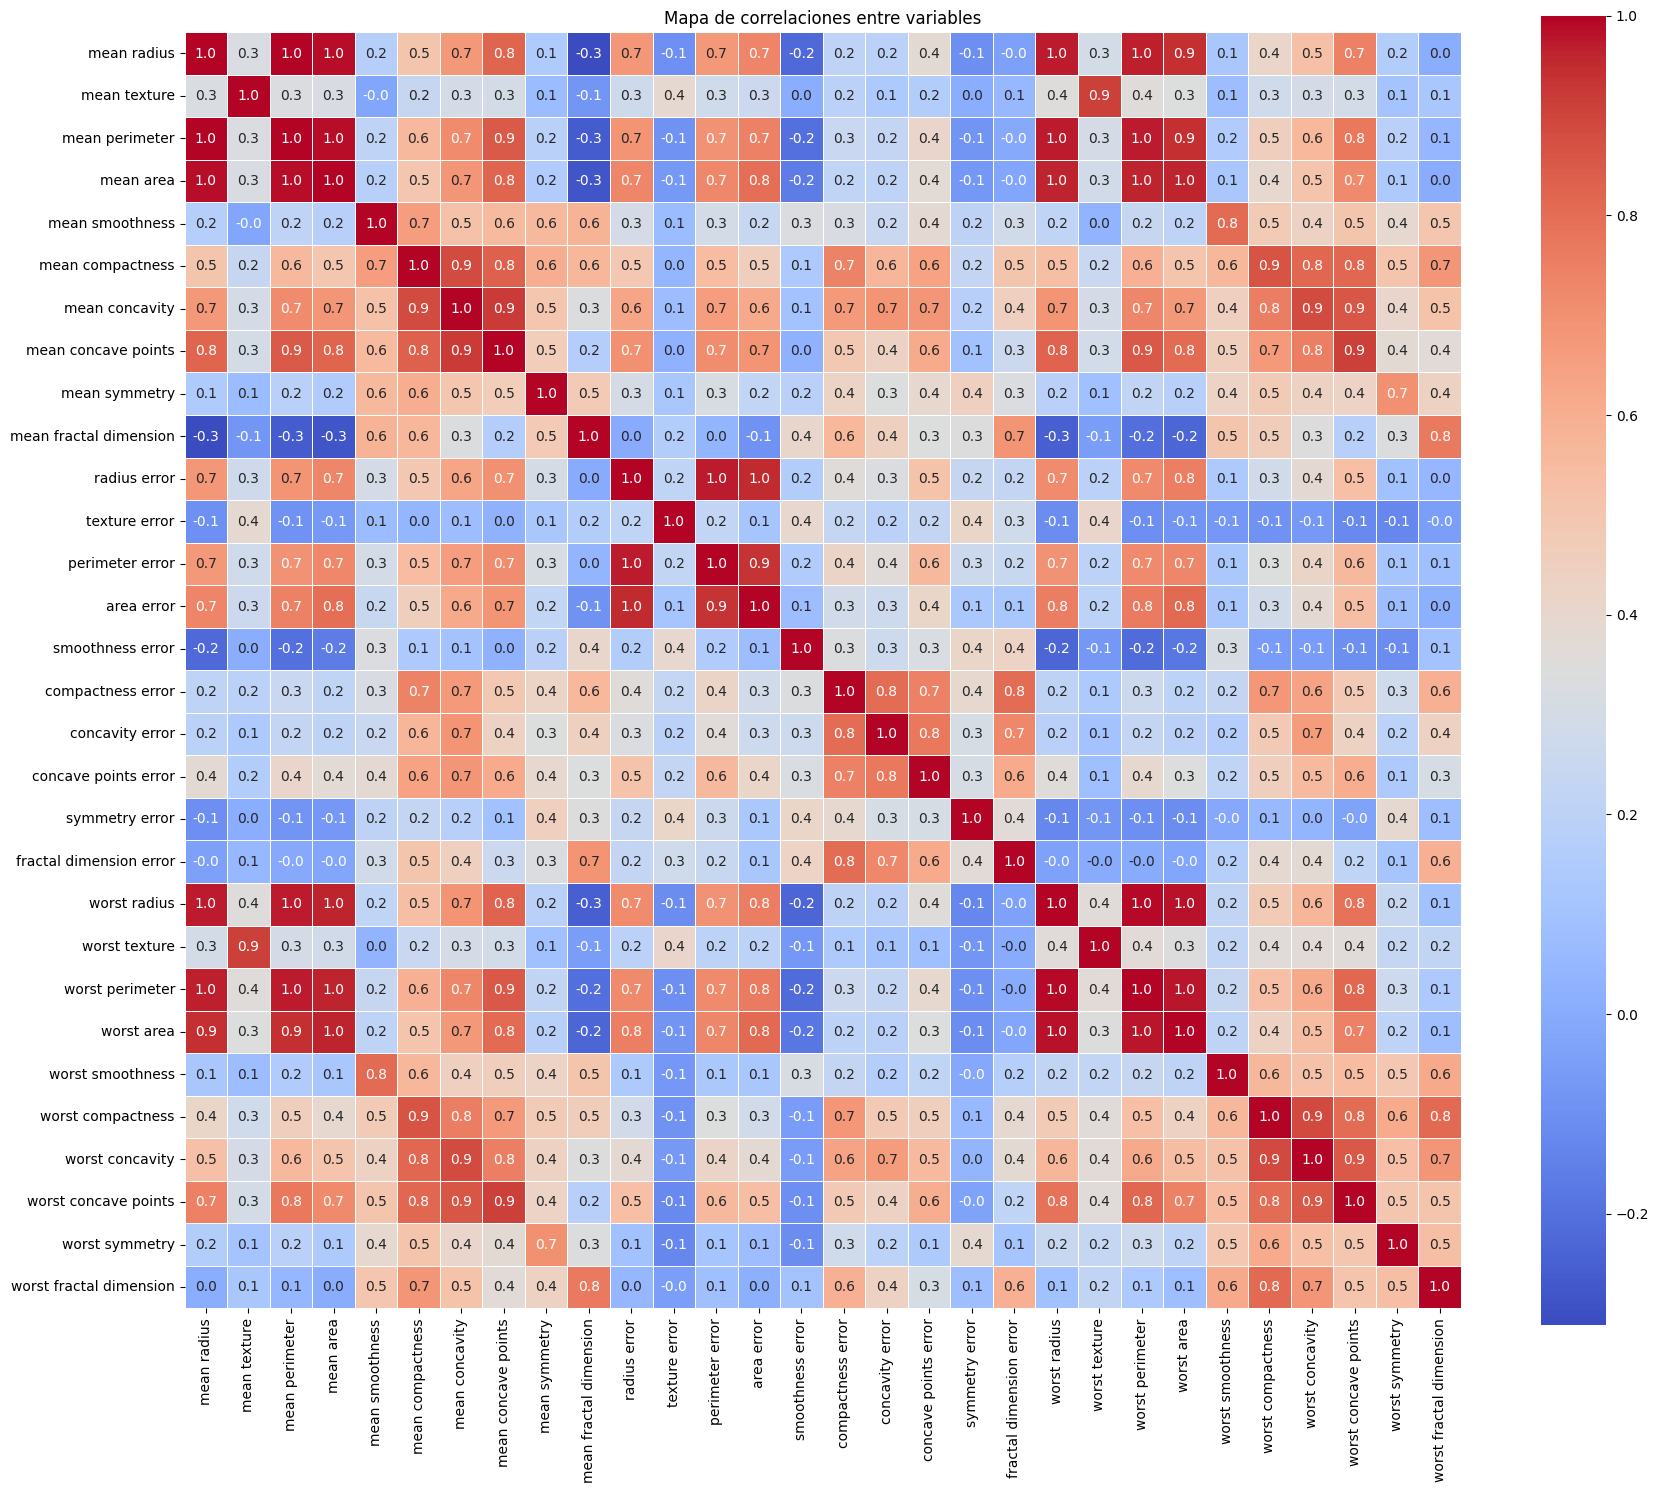

In [7]:
import seaborn as sns                     # Librería para gráficos estadísticos
import matplotlib.pyplot as plt           # Librería general de gráficos

# Calculamos la matriz de correlaciones
correlation_matrix = X_df.corr()          # Matriz de correlación de variables numéricas

# Dibujamos el mapa de calor con valores
plt.figure(figsize=(18, 15))              # Tamaño grande para que se vea todo
sns.heatmap(correlation_matrix,
            annot=True,                   # Mostrar los valores numéricos
            fmt=".1f",                    # Un decimal por celda
            cmap='coolwarm',              # Colores de contraste para correlaciones
            linewidths=0.5,               # Líneas divisorias
            square=True)                  # Hacer que las celdas sean cuadradas
plt.title('Mapa de correlaciones entre variables')
plt.tight_layout()
plt.show()


*Observaciones*:

Se observan grupos de variables con correlaciones altas, como:
  - `mean radius`, `mean perimeter`, `mean area` y `worst radius`, que presentan relaciones fuertes entre sí.
  - `mean concavity`, `mean compactness` y `mean concave points`, también estrechamente relacionadas.
  - Las variables que comienzan con `worst` (como `worst radius`, `worst perimeter`, `worst area`) tienden a estar correlacionadas con sus versiones `mean`.

Estas relaciones sugieren que hay información redundante en algunas variables, lo que podría afectar a modelos sensibles a la multicolinealidad, como la regresión logística.

Aunque no es estrictamente necesario eliminar variables, podría plantearse la reducción de dimensiones mediante técnicas como PCA o selección de características si se busca simplificar el modelo o mejorar el rendimiento computacional.

Aún no hemos entrenado modelos ni evaluado su desempeño. En esta etapa, es preferible mantener todas las variables para que el modelo tenga acceso a toda la información posible. Si posteriormente observamos sobreajuste, poca generalización, alta multicolinealidad en modelos sensibles (como regresión logística) o simplemente queremos optimizar velocidad o interpretabilidad …entonces sí podríamos aplicar selección de características o reducción de dimensionalidad (por ejemplo, PCA, SelectKBest, o eliminación manual de columnas con alta correlación).

### División de los datos

Dividimos el conjunto de datos original en dos subconjuntos: uno para entrenar el modelo (80%) y otro para evaluar su rendimiento sobre datos no vistos (20%). Se mantiene la proporción entre clases usando estratificación. No se aplicó re-muestreo, ya que el modelo considerará el desbalance mediante la opción class_weight='balanced'

In [8]:
from sklearn.model_selection import train_test_split  # Importa la función para dividir los datos

# Divide el conjunto de datos original en entrenamiento y prueba (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,                       # Datos originales sin re-muestreo
    test_size=0.2,              # 20% para prueba
    random_state=42,            # Fijamos semilla para reproducibilidad
    stratify=y                  # Mantiene la proporción de clases en ambos subconjuntos
)


### Entrenamiento del modelo

A continuación, entrenaremos tres modelos de clasificación distintos: regresión logística, K-vecinos (KNN) y árbol de decisión. Estos modelos se ajustarán con los datos de entrenamiento para aprender a predecir el diagnóstico (benigno o maligno) en base a las características del tumor.


In [10]:
# Importamos los clasificadores de sklearn
from sklearn.linear_model import LogisticRegression              # Regresión logística
from sklearn.neighbors import KNeighborsClassifier               # K-Vecinos (KNN)
from sklearn.tree import DecisionTreeClassifier                  # Árbol de decisión

# Creamos los modelos con parámetros básicos
model_lr = LogisticRegression(class_weight='balanced',          # Da más peso a la clase minoritaria
                              max_iter=10000,                    # Aumentamos iteraciones por seguridad
                              random_state=42)                  # Fijamos semilla para reproducibilidad

model_knn = KNeighborsClassifier()                              # Modelo KNN con parámetros por defecto

model_dt = DecisionTreeClassifier(class_weight='balanced',      # Peso automático según frecuencia de clases
                                  random_state=42)              # Semilla para reproducibilidad

# Entrenamos los modelos con los datos de entrenamiento
model_lr.fit(X_train, y_train)                                  # Entrena regresión logística
model_knn.fit(X_train, y_train)                                 # Entrena modelo KNN
model_dt.fit(X_train, y_train)                                  # Entrena árbol de decisión


DecisionTreeClassifier(class_weight='balanced', random_state=42)

### Evaluación

**Análisis de métricas**

Una vez entrenados los modelos, los evaluamos con los datos de prueba. Para cada uno mostraremos métricas habituales en clasificación: accuracy, precisión, recall y F1-score, lo que nos permitirá comparar su rendimiento.


In [11]:
# Importamos funciones para evaluar el modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Función para mostrar métricas clave de cada modelo
def evaluar_modelo(nombre, modelo):
    y_pred = modelo.predict(X_test)                             # Predecimos las etiquetas del test
    print(f'\n{nombre}')                                        # Mostramos el nombre del modelo
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.2f}')   # % de aciertos
    print(f'Precision: {precision_score(y_test, y_pred):.2f}')  # % de positivos predichos que eran correctos
    print(f'Recall:    {recall_score(y_test, y_pred):.2f}')     # % de positivos reales que se detectaron
    print(f'F1-score:  {f1_score(y_test, y_pred):.2f}')          # Media armónica entre precisión y recall

# Evaluamos los tres modelos creados
evaluar_modelo("Regresión logística", model_lr)
evaluar_modelo("K-Vecinos", model_knn)
evaluar_modelo("Árbol de decisión", model_dt)



Regresión logística
Accuracy:  0.94
Precision: 0.96
Recall:    0.94
F1-score:  0.95

K-Vecinos
Accuracy:  0.91
Precision: 0.94
Recall:    0.92
F1-score:  0.93

Árbol de decisión
Accuracy:  0.93
Precision: 0.96
Recall:    0.93
F1-score:  0.94


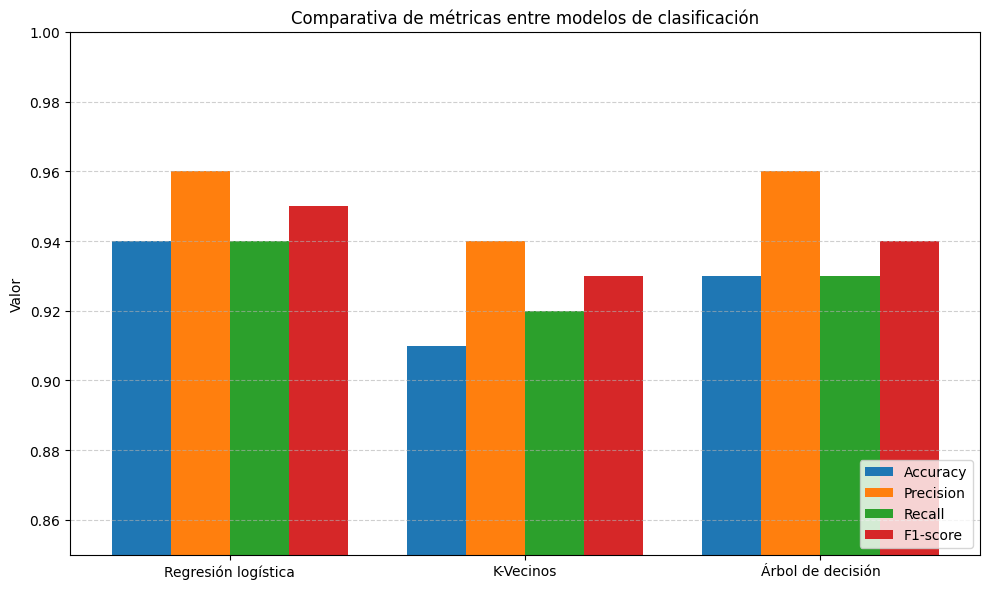

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Definimos los modelos y sus métricas
modelos = ['Regresión logística', 'K-Vecinos', 'Árbol de decisión']
accuracy = [0.94, 0.91, 0.93]
precision = [0.96, 0.94, 0.96]
recall = [0.94, 0.92, 0.93]
f1 = [0.95, 0.93, 0.94]

# Agrupamos los datos
metricas = [accuracy, precision, recall, f1]
n_modelos = len(modelos)
ancho = 0.2  # Ancho de las barras

x = np.arange(n_modelos)

# Creamos la figura
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5*ancho, accuracy, width=ancho, label='Accuracy')
ax.bar(x - 0.5*ancho, precision, width=ancho, label='Precision')
ax.bar(x + 0.5*ancho, recall, width=ancho, label='Recall')
ax.bar(x + 1.5*ancho, f1, width=ancho, label='F1-score')

# Añadimos etiquetas
ax.set_ylabel('Valor')
ax.set_ylim(0.85, 1.0)
ax.set_title('Comparativa de métricas entre modelos de clasificación')
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend(loc='lower right')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


*Observaciones*:

Tras entrenar y evaluar los tres modelos impartidos en clase sobre el conjunto de datos balanceado de cáncer de mama, obtenemos los siguientes resultados:

| Modelo               | Accuracy | Precision | Recall | F1-score |
|----------------------|----------|-----------|--------|----------|
| Regresión logística  | 0.94     | 0.96      | 0.94   | 0.95     |
| K-Vecinos (KNN)      | 0.91     | 0.94      | 0.92   | 0.93     |
| Árbol de decisión    | 0.93     | 0.96      | 0.93   | 0.94     |


- La regresión logística ofrece el rendimiento más equilibrado y ligeramente superior, siendo además rápida y fácil de interpretar.
- K-Vecinos tiene un buen comportamiento, aunque algo más sensible a los datos y puede requerir ajuste de `k`.
- El árbol de decisión se comporta también muy bien y tiene la ventaja de ser visualizable y muy intuitivo.

Todos los modelos son válidos en este contexto, pero la regresión logística podría considerarse la opción preferente si se busca simplicidad y rendimiento robusto.


**Análisis de sobreajuste**

A continuación, vamos a comprobar si alguno de los modelos entrenados muestra síntomas de sobreajuste (overfitting), es decir, si se comporta mucho mejor en el conjunto de entrenamiento que en el de prueba. Para ello compararemos el accuracy en ambos conjuntos para los tres clasificadores: regresión logística, k-vecinos y árbol de decisión.

In [14]:
from sklearn.metrics import accuracy_score  # Función para calcular precisión

# --- Regresión Logística ---
y_train_pred_lr = model_lr.predict(X_train)       # Predicción en entrenamiento con regresión logística
y_test_pred_lr  = model_lr.predict(X_test)        # Predicción en test con regresión logística
acc_train_lr = accuracy_score(y_train, y_train_pred_lr)  # Accuracy en entrenamiento
acc_test_lr  = accuracy_score(y_test, y_test_pred_lr)     # Accuracy en test

# --- K-Vecinos ---
y_train_pred_knn = model_knn.predict(X_train)     # Predicción en entrenamiento con KNN
y_test_pred_knn  = model_knn.predict(X_test)      # Predicción en test con KNN
acc_train_knn = accuracy_score(y_train, y_train_pred_knn)  # Accuracy en entrenamiento
acc_test_knn  = accuracy_score(y_test, y_test_pred_knn)     # Accuracy en test

# --- Árbol de Decisión ---
y_train_pred_dt = model_dt.predict(X_train)       # Predicción en entrenamiento con árbol de decisión
y_test_pred_dt  = model_dt.predict(X_test)        # Predicción en test con árbol de decisión
acc_train_dt = accuracy_score(y_train, y_train_pred_dt)    # Accuracy en entrenamiento
acc_test_dt  = accuracy_score(y_test, y_test_pred_dt)      # Accuracy en test

# Mostramos los resultados
print("Accuracy en entrenamiento vs test:")
print(f"Regresión Logística:  {acc_train_lr:.2f} (train) vs {acc_test_lr:.2f} (test)")
print(f"K-Vecinos:             {acc_train_knn:.2f} (train) vs {acc_test_knn:.2f} (test)")
print(f"Árbol de Decisión:     {acc_train_dt:.2f} (train) vs {acc_test_dt:.2f} (test)")


Accuracy en entrenamiento vs test:
Regresión Logística:  0.97 (train) vs 0.94 (test)
K-Vecinos:             0.95 (train) vs 0.91 (test)
Árbol de Decisión:     1.00 (train) vs 0.93 (test)


*Observaciones*:

Comparamos la precisión (accuracy) en los datos de entrenamiento y de test para detectar posibles casos de sobreajuste:

- **Regresión Logística**: obtiene un 97 % de acierto en entrenamiento y un 94 % en test. La diferencia es pequeña, por lo que el modelo generaliza bien.
- **K-Vecinos (KNN)**: también presenta un rendimiento algo superior en entrenamiento (95 %) frente al test (91 %), pero sin una diferencia excesiva.
- **Árbol de Decisión**: alcanza un 100 % en entrenamiento, lo que indica que ha memorizado los datos. Sin embargo, su rendimiento en test baja al 93 %. Esto revela un claro caso de sobreajuste.

En conclusión, el árbol de decisión es el que más tiende a sobreajustar, mientras que regresión logística y KNN generalizan mejor en este problema.


### Guardar el modelo

Una vez evaluados los modelos, seleccionamos el más adecuado para nuestro problema. En este caso, la regresión logística ha mostrado buen rendimiento y generalización, por lo que vamos a guardarla en disco para poder reutilizarla en el futuro sin necesidad de volver a entrenarla.

Guardar modelo:

In [15]:
import joblib                                     # Librería para guardar modelos de scikit-learn fácilmente

modelo_path = "modelo_regresion_logistica.pkl"    # Nombre del archivo donde guardaremos el modelo
joblib.dump(model_lr, modelo_path)                # Guardamos el modelo entrenado en el fichero especificado
print(f"Modelo guardado como '{modelo_path}'")    # Confirmamos por consola el guardado


Modelo guardado como 'modelo_regresion_logistica.pkl'


Cargar modelo:

In [16]:
modelo_cargado = joblib.load("modelo_regresion_logistica.pkl")   # Cargamos el modelo desde el fichero .pkl

### Uso del modelo

A continuación se muestra cómo usar el modelo guardado para realizar nuevas predicciones sobre ejemplos desconocidos, compararlas con los valores reales y observar la probabilidad estimada para cada clase.


In [21]:
nuevas_predicciones = modelo_cargado.predict(X_test[:5])      # Predice la clase (0 o 1) para los 5 primeros casos de test
print("Predicciones:", nuevas_predicciones)                   # Muestra las clases predichas por el modelo

print("Valores reales:", y_test[:5].values)                   # Muestra los valores reales de las clases para esos mismos casos

probabilidades = modelo_cargado.predict_proba(X_test[:5])     # Calcula las probabilidades de pertenecer a cada clase (0 y 1)
print("Probabilidades de clase 0 y 1:\n", probabilidades)     # Muestra las probabilidades en forma de array 5x2


Predicciones: [0 1 0 0 0]
Valores reales: [0 1 0 1 0]
Probabilidades de clase 0 y 1:
 [[1.00000000e+00 1.30956983e-11]
 [5.07090566e-05 9.99949291e-01]
 [9.71601687e-01 2.83983134e-02]
 [5.16613722e-01 4.83386278e-01]
 [9.99999999e-01 5.79364968e-10]]


*Observaciones*:

Una vez cargado el modelo, podemos usarlo para hacer predicciones sobre nuevos datos. A continuación se muestran los resultados para 5 ejemplos del conjunto de test:

| Nº | Predicción | Valor real | Prob. clase 0 | Prob. clase 1 | ¿Correcto? | Confianza alta |
|----|------------|------------|----------------|----------------|------------|----------------|
| 1  | 0          | 0          | 1.00           | ≈0             | Sí         | Sí  
| 2  | 1          | 1          | 0.00005        | 0.99995        | Sí         | Sí  
| 3  | 0          | 0          | 0.9716         | 0.0284         | Sí         | Sí  
| 4  | 0          | 1          | 0.5166         | 0.4834         | No         | No  
| 5  | 0          | 0          | ≈1.00          | ≈0             | Sí         | Sí  


El modelo ha acertado 4 de las 5 predicciones, es decir, un 80 %.  

Este porcentaje no contradice el 94 % de accuracy global, ya que esta muestra es muy pequeña y puede no ser representativa. En evaluaciones estadísticas, se necesita un número mayor de muestras para obtener un valor fiable.

El único error (caso 4) se produce en una situación ambigua, con probabilidades cercanas al 50 %, lo que indica que el modelo no tenía una clara preferencia por ninguna clase. Este tipo de análisis puede ayudar a identificar casos límite o a mejorar la interpretación del modelo.
